# Card Sorter
    by E. Favari and G. Grillo, 29/03/2021

This notebook aims at showing our current progress on the software concerning the _Card Sorter_ for [Fantasia Store](https://fantasiastore.it/it/).

## Database download

We relay on the database [https://mtgjson.com/](!https://mtgjson.com/) and download the images from [https://scryfall.com/](!https://scryfall.com/) using the unique code provided by the database. This database contains all the main information about all the cards available in various languages and it is periodically updated.

In [51]:
import os
import json
import requests

# General Variables
url_db = 'https://mtgjson.com/api/v5/AllPrintings.json'
saveLocation = './AllPrintings.json'
force_download = False

# Variable used for the image download
image_id_wildcard = '${card.identifiers.scryfallId}'
image_url = 'https://api.scryfall.com/cards/${card.identifiers.scryfallId}?format=image'

In [52]:
# Download database from the site
if ( not os.path.isfile(saveLocation) ) or force_download:
    r = requests.get(url_db, allow_redirects=True)
    open(saveLocation, 'wb').write(r.content);

with open(saveLocation, 'r', encoding="utf8") as json_file:
  magic_sets = json.load(json_file)
  magic_sets = magic_sets['data']
    
print("Current working Directory:", os.getcwd())
print("Loaded file", saveLocation)

Current working Directory: D:\GitRepositories\CardSorterFantasia\MagicDatabaseDownloader
Loaded file ./AllPrintings.json


## Tesseract Feature test
[Tesseract](https://github.com/tesseract-ocr) is an Optical Character Recognition (OCS) software which, after some preprocessing, is able to extract text from images.  
We now aim to test its capability to recognize the text in a Magic card.

In [53]:
# library import and constant definition
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from skimage.color import rgb2gray

import pytesseract

import random

from pathlib import Path

In [54]:
# Auxiliary functions
def black_over_white(img):
    # This function transforms an image into a greyscale and then
    # exchange the brightness. This is useful as tesseract works at
    # it's best on black text over white background while magic
    # cards are light text on dark background.
    grayscale = rgb2gray(img)*255
    grayscale[850:,:300] = 255*(1-rgb2gray(img[850:,:300]) )
    grayscale = grayscale.astype(np.uint8)
    return grayscale


def display_image(ax, img, grayscale, text):
    # This function prints a brief recap
    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[1].imshow(grayscale, cmap=plt.cm.gray)
    ax[1].set_title("Black over White")
    ax[2].imshow(255-0*img)
    ax[2].text(350, 450, text, ha='center', va='center', fontsize=9)
    
    
def get_card_img(card):
    # Funzione principale incaricata di scaricare le carte
    filename = "cards_db/"+card['setCode'] + "/"+ card['rarity'] + "/" + card['number'] + ".jpg"
    if not os.path.isfile(filename):
        Path("cards_db/"+card['setCode'] + "/"+ card['rarity'] + "/").mkdir(parents=True, exist_ok=True)

        scryfallId = card['identifiers']['scryfallId']

        url_img = image_url.replace(image_id_wildcard, scryfallId)
        r = requests.get(url_img, allow_redirects=True)
        open(filename, 'wb').write(r.content)
    
    return  mpimg.imread(filename).astype(np.uint8)

def pick_random_card():
    rnd_ms = random.choice( list(magic_sets.keys()) )
    rnd_card = None

    while (not rnd_ms) or \
          (magic_sets[rnd_ms]['releaseDate'] < '2015-01-01') or \
           len(magic_sets[rnd_ms]['cards']) == 0:
        rnd_ms = random.choice( list(magic_sets.keys()) )
    
    while not rnd_card:
        rnd_card = random.choice(magic_sets[rnd_ms]['cards'])

    return rnd_card

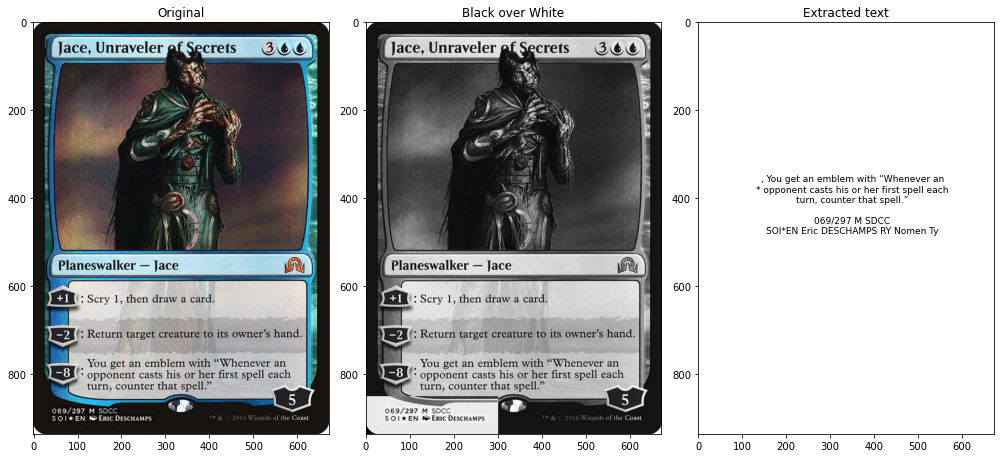

In [55]:
TEST_CASES = 1

for i in range(TEST_CASES):
    fig, ax = plt.subplots(1, 3, figsize=(14, 8), gridspec_kw={'width_ratios': [1, 1, 1]})
    
    # Pick a random card
    rnd_card = pick_random_card()
    while not 'paper' in rnd_card['availability']:
        rnd_card = pick_random_card()
     
    img = get_card_img(rnd_card)
    
    grayscale = black_over_white(img)

    tesseract_text = pytesseract.image_to_string(grayscale)
    tesseract_text = str.rstrip(tesseract_text)
    
    display_image(ax, img, grayscale, tesseract_text[:-2])
    
    ax[2].set_title("Extracted text")

fig.tight_layout()
plt.show()

## Indexing - Reverse search
Now that we can extract text from an image we are going to search corresponding card using the text extracted. To do that we first need to generate an index and a dictionary of the words available.

### Index

In [56]:
import re

# The index is incapsulated in an object so that it's easier to save and load it without
# having to recalculate it each time
class Index:
    def __init__(self):
        self.index = {}
        self.cards = {}

    def add(self, card, card_id, keywords):
        if card_id not in self.cards:
            self.cards[card_id] = card

        for keyword in keywords:
            if len(keyword) > 3:
                if keyword not in self.index:
                    self.index[keyword] = set()

                self.index[keyword].add(card_id)    
    
    def _results(self, query):
        return [self.index.get(keyword, set()) for keyword in query]

    def search(self, query):
        results = self._results(query)
        cards = [self.cards[card_id] for card_id in set.intersection(*results)]
        return cards
    
    
    def standardize_keywords(self, text):
        std_text = text.lower()
        # 0-9+\/
        std_text = re.sub('[^a-z\s]+', '', std_text)
        std_text = re.sub('\n', ' ', std_text)

        keywords = set(std_text.split(' ') )
        keywords.discard('')

        return keywords
    
    
    def in_dictionary(self, keyword):
        if keyword in 'wizards of the coast':
           return False;
        if keyword in self.index.keys():
            return True
        else:
            return False

index = Index()

In [57]:
# Add cards into the database
for ms in magic_sets:
    for card in magic_sets[ms]['cards']:
        if 'paper' in card['availability']:
            flavorText = card['flavorText'] if 'flavorText' in card else ''
            originalText = card['originalText'] if 'originalText' in card else ''
            text = card['text'] if 'text' in card else ''
            name = card['name'] if 'name' in card else ''
            flavorName = card['flavorName'] if 'flavorName' in card else ''
            card_type = card['type'] if 'type' in card else '' 
            artist = card['artist'] if 'artist' in card else ''

            all_text = flavorText+' '+ originalText+' '+ text+' '+ name+' '+ flavorName + card_type + artist;
            keywords = index.standardize_keywords(all_text)
            
            card_id = ms+'-'+card['number']
            
            index.add(card, card_id, keywords)

In [58]:
keywords = index.standardize_keywords(tesseract_text) 
for kwd in keywords.copy():
    if not index.in_dictionary(kwd):
        keywords.discard(kwd)

print("Keywords found: ", keywords, "\n")

res = index.search(keywords)

i = 0
while len(res) == 0:
    key_list = list(keywords)
    to_remove = key_list[i]
    key_list.remove( to_remove )
    res = index.search( key_list )
    i += 1

if i > 0:
    print("REMOVED WORD --> ", key_list[i])

print("Number of occurence found: ", len(res))
for i, r in enumerate(res):
    print("\n\n------------------------------ Occurence ", str(i+1), "------------------------------\n")
    print("Name:", r['name'])
    print("Set code:", r['setCode'])
    print("Rarity:", r['rarity'])
    print("Unique entries:")
    
    for entry in r:
        if not entry in ['foreignData', 'identifiers', 'uuid', 'variations']:
            unique = True

            for r2 in res:
                if not r == r2:
                    if (entry in r2) and (r[entry] == r2[entry]):
                        unique = False
            if unique:
                print("\t",entry, ":", r[entry])

Keywords found:  {'turn', 'with', 'opponent', 'emblem', 'casts', 'whenever', 'deschamps', 'counter', 'first', 'that', 'spell', 'each'} 

Number of occurence found:  1


------------------------------ Occurence  1 ------------------------------

Name: Jace, Unraveler of Secrets
Set code: PS16
Rarity: mythic
Unique entries:
	 artist : Eric Deschamps
	 availability : ['paper']
	 borderColor : black
	 colorIdentity : ['U']
	 colors : ['U']
	 convertedManaCost : 5.0
	 edhrecRank : 1836
	 frameVersion : 2015
	 hasFoil : True
	 hasNonFoil : False
	 isPromo : True
	 isReprint : True
	 isStarter : True
	 keywords : ['Scry']
	 layout : normal
	 leadershipSkills : {'brawl': False, 'commander': False, 'oathbreaker': True}
	 legalities : {'commander': 'Legal', 'duel': 'Legal', 'gladiator': 'Legal', 'historic': 'Legal', 'legacy': 'Legal', 'modern': 'Legal', 'pioneer': 'Legal', 'vintage': 'Legal'}
	 loyalty : 5
	 manaCost : {3}{U}{U}
	 name : Jace, Unraveler of Secrets
	 number : 69
	 printings : ['A

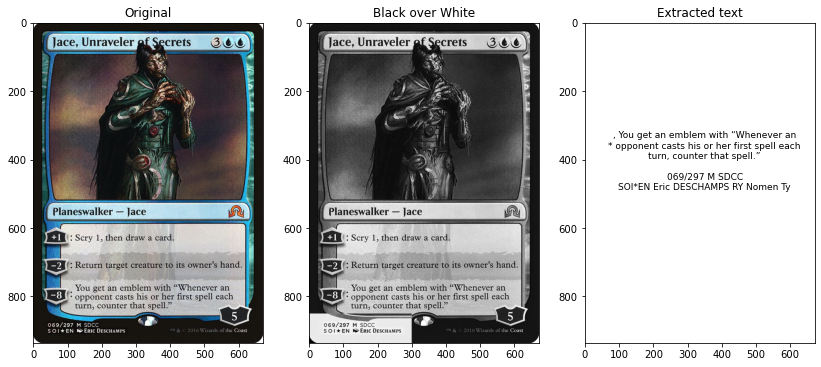

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(14, 8), gridspec_kw={'width_ratios': [1, 1, 1]})
display_image(ax, img, grayscale, tesseract_text[:-2])
ax[2].set_title("Extracted text");

In [60]:
for i, r in enumerate(res):
    print("\n\n------------------------------ Occurence ", str(i+1), "------------------------------\n")
    print(r)



------------------------------ Occurence  1 ------------------------------

{'artist': 'Eric Deschamps', 'availability': ['paper'], 'borderColor': 'black', 'colorIdentity': ['U'], 'colors': ['U'], 'convertedManaCost': 5.0, 'edhrecRank': 1836, 'foreignData': [], 'frameVersion': '2015', 'hasFoil': True, 'hasNonFoil': False, 'identifiers': {'cardKingdomFoilId': '207938', 'mcmId': '291361', 'mtgjsonV4Id': '12548fcf-b6db-5c20-9451-684042aad87a', 'scryfallId': '40902291-96ad-410f-9ff9-bdd3d4cdea65', 'scryfallIllustrationId': 'c88f3159-8f34-4b07-89ea-a8e12116365b', 'scryfallOracleId': 'ac29873e-28c3-4933-b427-61d34ff0afcd', 'tcgplayerProductId': '120961'}, 'isPromo': True, 'isReprint': True, 'isStarter': True, 'keywords': ['Scry'], 'layout': 'normal', 'leadershipSkills': {'brawl': False, 'commander': False, 'oathbreaker': True}, 'legalities': {'commander': 'Legal', 'duel': 'Legal', 'gladiator': 'Legal', 'historic': 'Legal', 'legacy': 'Legal', 'modern': 'Legal', 'pioneer': 'Legal', 'vintage'